In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import ksig

In [2]:
n_levels = 5
# number of signature levels to use

# static_kernel = ksig.static.kernels.RBFKernel()
# an RBF base kernel for vector-valued data which is lifted to a kernel for sequences

static_kernel = ksig.static.kernels.LinearKernel()

sig_kernel = ksig.kernels.SignatureKernel(n_levels, static_kernel=static_kernel)
# a SignatureKernel object, which works as a callable for computing the signature kernel matrix

n_seq, l_seq, n_feat = 10, 50, 5
X = np.random.randn(n_seq, l_seq, n_feat)
# generate 10 sequences of length 50 with 5 features

K_XX = sig_kernel(X) # K_XX has shape (10, 10)
# compute the signature kernel matrix k(X, X)
# more efficient than calling sig_kernel(X, X)

K_X = sig_kernel(X, diag=True) # K_X has shape (10,)
# compute only the diagonal entries of the signature kernel matrix

n_seq2, l_seq2 = 8, 20
Y = np.random.randn(n_seq2, l_seq2, n_feat)
# generate another array of 8 sequences of length 20 and 5 features

# K_XY = sig_kernel(X, Y) # K_XY has shape (10, 8)
# # compute the kernel matrix between arrays X and Y

In [3]:
# simulate geometric Brownian motion paths
mu_x = 0.1
sigma_x = 0.2
mu_y = 0.2
sigma_y = 0.2
n_paths = 200
n_steps = 60 - 1
dt = 1/252
X = np.exp((mu_x - 0.5 * sigma_x**2) * dt + sigma_x * np.sqrt(dt) * np.random.randn(n_paths, n_steps))
Y = np.exp((mu_y - 0.5 * sigma_y**2) * dt + sigma_y * np.sqrt(dt) * np.random.randn(n_paths, n_steps))
X = np.cumprod(X, axis=1)
Y = np.cumprod(Y, axis=1)
X = np.concatenate([np.ones((n_paths, 1)), X], axis=1)
Y = np.concatenate([np.ones((n_paths, 1)), Y], axis=1)
X = X[..., np.newaxis]
Y = Y[..., np.newaxis]
X.shape, Y.shape

((200, 60, 1), (200, 60, 1))

In [4]:
def two_sample_permutation_test(test_statistic, X, Y, num_permutations):
    assert X.ndim == Y.ndim

    statistics = np.zeros(num_permutations)

    for i in range(num_permutations):
        # concatenate samples
        if X.ndim == 1:
            Z = np.hstack((X,Y))
        elif X.ndim > 1:
            Z = np.vstack((X,Y))
        # permute samples and compute test statistic
        perm_inds = np.random.permutation(len(Z))
        Z = Z[perm_inds]
        X_ = Z[:len(X)]
        Y_ = Z[len(X):]
        my_test_statistic = test_statistic(X_, Y_)
        statistics[i] = my_test_statistic
    return statistics

def quadratic_time_mmd(X,Y,kernel):
    # assert X.ndim == Y.ndim == 2
    K_XX = kernel(X,X)
    K_XY = kernel(X,Y)
    K_YY = kernel(Y,Y)

    n = len(K_XX)
    m = len(K_YY)

    # unbiased MMD statistic (could also use biased, doesn't matter if we use permutation tests)
    np.fill_diagonal(K_XX, 0)
    np.fill_diagonal(K_YY, 0)
    mmd = np.sum(K_XX) / (n*(n-1))  + np.sum(K_YY) / (m*(m-1))  - 2*np.sum(K_XY)/(n*m)
    return mmd

def plot_permutation_samples(null_samples, statistic=None):
    plt.hist(null_samples)
    plt.axvline(x=np.percentile(null_samples, 2.5), c='b')
    legend = ["95% quantiles"]
    if statistic is not None:
        plt.axvline(x=statistic, c='r')
        legend += ["Actual test statistic"]
    plt.legend(legend)
    plt.axvline(x=np.percentile(null_samples, 97.5), c='b')
    plt.xlabel("Test statistic value")
    plt.ylabel("Counts")

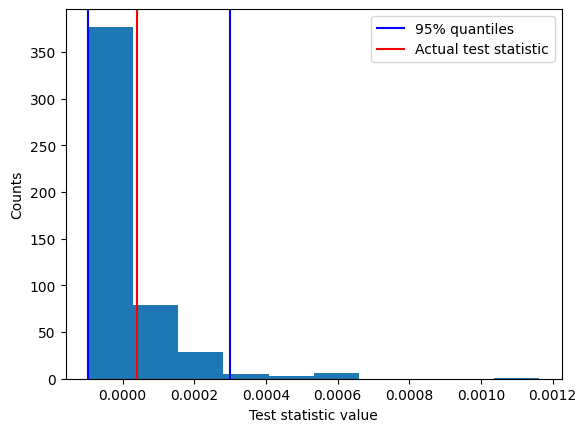

In [5]:
num_permutations = 500

my_kernel = lambda X,Y : sig_kernel(X, Y)
my_mmd = lambda X,Y : quadratic_time_mmd(X, Y, my_kernel)

statistics = two_sample_permutation_test(my_mmd, X, Y, num_permutations)
my_statistic = my_mmd(X,Y)

plot_permutation_samples(statistics, my_statistic)